# EECS 448 Drunk Accelerometer Model Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random as random

from tqdm import tqdm

## Analyzing Key Aspects of Data

In [203]:
features_df = pd.read_parquet("balanced_features.parquet")

features_df

,time,pid,x_mean,y_mean,z_mean,mag_mean,x_std,y_std,z_std,mag_std,...,y_max,z_max,mag_max,time_entropy,frequency_entropy,spectral_centroid,spectral_spread,spectral_flux,spectral_rolloff,TAC_class
0,2017-05-02 14:04:40,SA0297,-0.222442,-0.075598,-0.015889,0.242998,6.988053e-02,3.550172e-02,7.062066e-03,5.092628e-02,...,0.0861,0.0849,0.293697,6.161106e-01,0.025375,3.205993e+04,9.724189e+08,1.265986e+04,392,0.0
0,2017-05-02 14:04:44,SA0297,0.009088,-0.042815,-0.008202,0.073136,3.185934e-02,5.166347e-02,2.756228e-02,3.283147e-02,...,0.1881,0.1161,0.227391,2.089842e+00,0.049024,-1.743570e+04,3.120597e+08,1.920136e+03,987,0.0
0,2017-05-02 14:04:48,SA0297,0.000233,0.000279,-0.012446,0.056119,2.208625e-02,1.088092e-02,5.806136e-02,3.135288e-02,...,0.0324,0.1393,0.146422,2.926396e+00,0.247524,8.175000e+02,5.876386e+05,1.740432e+03,990,0.0
0,2017-05-02 14:04:52,SA0297,0.015000,0.012800,-0.025800,0.032473,6.938894e-18,3.469447e-18,6.938894e-18,6.938894e-18,...,0.0128,0.0258,0.032473,-1.442695e-10,0.011408,3.105155e-13,1.286114e-10,4.000000e+00,0,0.0
0,2017-05-02 14:04:56,SA0297,0.028955,0.019178,-0.011516,0.118029,1.039950e-01,5.769088e-02,1.421302e-01,1.474860e-01,...,0.2176,0.7028,0.715980,1.300715e+00,0.308401,-1.730865e+04,-7.448975e+06,3.402120e+03,991,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2017-05-02 22:58:24,DK3500,-0.282059,0.812773,0.919243,1.494816,5.524381e-01,7.710623e-01,4.508139e-01,6.735337e-01,...,3.6328,2.8105,4.068333,2.195081e+00,0.011408,1.963719e+05,3.852014e+10,2.606618e+06,973,0.0
0,2017-05-02 22:58:28,DK3500,-0.398836,0.841703,0.873992,1.500703,5.797443e-01,6.457703e-01,4.180652e-01,5.542438e-01,...,2.2785,2.4691,3.493737,2.831896e+00,0.011408,-1.217293e+05,1.479031e+10,1.813968e+06,985,0.0
0,2017-05-02 22:58:32,DK3500,-0.395525,0.851949,0.918978,1.517392,5.291713e-01,6.721786e-01,4.653721e-01,6.105056e-01,...,3.0226,2.8839,3.568501,2.319288e+00,0.011408,-9.660115e+04,9.315850e+09,2.201106e+06,975,0.0
0,2017-05-02 22:58:36,DK3500,-0.445867,0.862403,0.879934,1.460645,4.950609e-01,5.739813e-01,3.984550e-01,5.627110e-01,...,1.9277,2.4865,3.384682,2.608129e+00,0.011408,-6.160347e+05,3.677053e+11,1.677647e+06,981,0.0


In [204]:
pids = list(features_df['pid'].unique())

pids

['SA0297',
 'PC6771',
 'BK7610',
 'DC6359',
 'MC7070',
 'MJ8002',
 'BU4707',
 'JR8022',
 'HV0618',
 'SF3079',
 'JB3156',
 'CC6740',
 'DK3500']

In [205]:
data = [(pid,
         len(features_df.loc[features_df['pid'] == pid]),  # Total count for the pid
         len(features_df.loc[(features_df['pid'] == pid) & (features_df['TAC_class'] == 1)]))  # Count for pid and TAC_class == 1
        for pid in pids]

feature_summary = pd.DataFrame(data, columns=['pid', 'length', 'num_drunk'])
feature_summary['pct_drunk'] = round(feature_summary['num_drunk'] / feature_summary['length'], 3)
feature_summary.set_index('pid', inplace=True)

feature_summary

,length,num_drunk,pct_drunk
pid,,,
SA0297,11630,2885,0.248
PC6771,6197,931,0.150
BK7610,7975,2226,0.279
DC6359,8145,3186,0.391
MC7070,10903,2921,0.268
MJ8002,7912,3459,0.437
BU4707,5105,625,0.122
JR8022,8522,838,0.098
HV0618,8550,935,0.109


## Calculating Model Metrics

In [245]:
def process_metrics(df, model_type):
    # making sure a dot product is suitable
    assert list(df['pid']) == list(feature_summary.index)

    # precision = true_positives / (true_positives + false_positives)
    # recall = true_positives / (true_positives + false_negatives)
    df['precision'] = round(df['drunk_correct_raw'] / (df['drunk_correct_raw'] + df['drunk_incorrect_raw']), 3)
    df['recall'] = round(df['drunk_correct_raw'] / (df['drunk_correct_raw'] + df['sober_incorrect_raw']), 3)

    model_df = df[['pid', 'sober_correct', 'sober_incorrect', 'drunk_correct', 'drunk_incorrect', 'precision', 'recall']]

    weighted_avg_sober_correct = np.dot(df['sober_correct'], feature_summary['length']) / np.sum(feature_summary['length'])
    weighted_avg_drunk_correct = np.dot(df['drunk_correct'], feature_summary['length']) / np.sum(feature_summary['length'])
    weighted_avg_precision = np.dot(df['precision'], feature_summary['length']) / np.sum(feature_summary['length'])
    weighted_avg_recall = np.dot(df['recall'], feature_summary['length']) / np.sum(feature_summary['length'])

    weighted_avg_df = pd.DataFrame({'pid': [model_type],
                                    'sober_correct': [weighted_avg_sober_correct],
                                    'sober_incorrect': [100 - weighted_avg_sober_correct],
                                    'drunk_correct': [weighted_avg_drunk_correct],
                                    'drunk_incorrect': [100 - weighted_avg_drunk_correct],
                                    'precision': [weighted_avg_precision],
                                    'recall': [weighted_avg_recall]})

    model_df = pd.concat([model_df, weighted_avg_df], ignore_index=True)

    return weighted_avg_df, model_df

In [246]:
baseline_results = pd.read_parquet('baseline_cm_data.parquet')

baseline_results

,pid,sober_correct,sober_incorrect,drunk_correct,drunk_incorrect,sober_correct_raw,sober_incorrect_raw,drunk_correct_raw,drunk_incorrect_raw
0,SA0297,95.769011,4.230989,4.956672,95.043328,8375,370,143,2742
1,PC6771,49.183441,50.816559,13.211600,86.788400,2590,2676,123,808
2,BK7610,90.259176,9.740824,13.297394,86.702606,5189,560,296,1930
3,DC6359,95.624118,4.375882,4.456999,95.543001,4742,217,142,3044
4,MC7070,98.509146,1.490854,68.195823,31.804177,7863,119,1992,929
5,MJ8002,61.621379,38.378621,69.268575,30.731425,2744,1709,2396,1063
6,BU4707,95.959821,4.040179,8.000000,92.000000,4299,181,50,575
7,JR8022,75.117126,24.882874,3.818616,96.181384,5772,1912,32,806
8,HV0618,97.491793,2.508207,3.208556,96.791444,7424,191,30,905
9,SF3079,98.624067,1.375933,7.246377,92.753623,8458,118,125,1600


In [251]:
baseline_avgs, baseline_metrics = process_metrics(baseline_results, 'Baseline Random Forest Avg.')

baseline_metrics

,pid,sober_correct,sober_incorrect,drunk_correct,drunk_incorrect,precision,recall
0,SA0297,95.769011,4.230989,4.956672,95.043328,0.050000,0.27900
1,PC6771,49.183441,50.816559,13.211600,86.788400,0.132000,0.04400
2,BK7610,90.259176,9.740824,13.297394,86.702606,0.133000,0.34600
3,DC6359,95.624118,4.375882,4.456999,95.543001,0.045000,0.39600
4,MC7070,98.509146,1.490854,68.195823,31.804177,0.682000,0.94400
5,MJ8002,61.621379,38.378621,69.268575,30.731425,0.693000,0.58400
6,BU4707,95.959821,4.040179,8.000000,92.000000,0.080000,0.21600
7,JR8022,75.117126,24.882874,3.818616,96.181384,0.038000,0.01600
8,HV0618,97.491793,2.508207,3.208556,96.791444,0.032000,0.13600
9,SF3079,98.624067,1.375933,7.246377,92.753623,0.072000,0.51400


In [248]:
gb_results = pd.read_parquet('gb_cm_data.parquet')

gb_results

,pid,sober_correct,sober_incorrect,drunk_correct,drunk_incorrect,sober_correct_raw,sober_incorrect_raw,drunk_correct_raw,drunk_incorrect_raw
0,SA0297,99.245283,0.754717,0.970537,99.029463,8679,66,28,2857
1,PC6771,94.360046,5.639954,8.700322,91.299678,4969,297,81,850
2,BK7610,95.251348,4.748652,9.299191,90.700809,5476,273,207,2019
3,DC6359,98.104457,1.895543,3.107345,96.892655,4865,94,99,3087
4,MC7070,99.899774,0.100226,4.347826,95.652174,7974,8,127,2794
5,MJ8002,97.013249,2.986751,1.590055,98.409945,4320,133,55,3404
6,BU4707,99.330357,0.669643,1.760000,98.240000,4450,30,11,614
7,JR8022,75.611661,24.388339,1.789976,98.210024,5810,1874,15,823
8,HV0618,96.034143,3.965857,2.352941,97.647059,7313,302,22,913
9,SF3079,24.825093,75.174907,6.724638,93.275362,2129,6447,116,1609


In [250]:
gb_avgs, gb_metrics = process_metrics(gb_results, "Gradient Boosted Model Avg.")

gb_metrics

,pid,sober_correct,sober_incorrect,drunk_correct,drunk_incorrect,precision,recall
0,SA0297,99.245283,0.754717,0.970537,99.029463,0.010000,0.298000
1,PC6771,94.360046,5.639954,8.700322,91.299678,0.087000,0.214000
2,BK7610,95.251348,4.748652,9.299191,90.700809,0.093000,0.431000
3,DC6359,98.104457,1.895543,3.107345,96.892655,0.031000,0.513000
4,MC7070,99.899774,0.100226,4.347826,95.652174,0.043000,0.941000
5,MJ8002,97.013249,2.986751,1.590055,98.409945,0.016000,0.293000
6,BU4707,99.330357,0.669643,1.760000,98.240000,0.018000,0.268000
7,JR8022,75.611661,24.388339,1.789976,98.210024,0.018000,0.008000
8,HV0618,96.034143,3.965857,2.352941,97.647059,0.024000,0.068000
9,SF3079,24.825093,75.174907,6.724638,93.275362,0.067000,0.018000


In [266]:
model_avgs = pd.concat([baseline_avgs, gb_avgs], ignore_index=True).T
model_avgs = model_avgs.rename(columns=model_avgs.iloc[0]).drop(model_avgs.index[0])

# removing the incorrect percentages
model_avgs = model_avgs.drop(model_avgs.index[3]).drop(model_avgs.index[1])

model_avgs.to_csv("model_avg_metrics.csv")

model_avgs

,Baseline Random Forest Avg.,Gradient Boosted Model Avg.
sober_correct,82.179437,85.250561
drunk_correct,24.289439,7.74298
precision,0.242916,0.077515
recall,0.35859,0.349472


## Analyzing Feature Importance

In [226]:
def process_feature_importances(df):
    # making sure a dot product is suitable
    df_t = df.T
    assert list(df_t.index) == list(feature_summary.index)
    df_t = df_t.reset_index()

    weighted_avg_dict = {'index': 'Weighted Avg.'}
    for feature in df_t.columns[1:]:
        weighted_avg = np.dot(df_t[feature], feature_summary['length']) / np.sum(feature_summary['length'])
        weighted_avg_dict[feature] = weighted_avg

    weighted_avg_df = pd.DataFrame(weighted_avg_dict, index=[0])
    df_t = pd.concat([df_t, weighted_avg_df], ignore_index=True)

    df_t = df_t.T
    df_t = df_t.rename(columns=df_t.iloc[0]).drop(df_t.index[0])
    df_t = df_t.sort_values(by='Weighted Avg.', ascending=False)

    return df_t

In [231]:
baseline_importances = pd.read_parquet('baseline_feature_importance.parquet')
baseline_importances = process_feature_importances(baseline_importances)

baseline_importances

,SA0297,PC6771,BK7610,DC6359,MC7070,MJ8002,BU4707,JR8022,HV0618,SF3079,JB3156,CC6740,DK3500,Weighted Avg.
y_max,0.073715,0.074247,0.081094,0.085975,0.071538,0.087608,0.081852,0.079875,0.07866,0.079885,0.078093,0.068954,0.064397,0.077291
x_max,0.087462,0.077331,0.078712,0.075967,0.076904,0.068331,0.07967,0.072686,0.086201,0.070303,0.072504,0.07122,0.074305,0.076352
z_max,0.071956,0.073711,0.076481,0.072726,0.078782,0.058413,0.069149,0.065106,0.076724,0.076235,0.069595,0.072035,0.056555,0.071303
spectral_flux,0.061358,0.058067,0.059064,0.066603,0.067999,0.088801,0.068273,0.067177,0.062115,0.066661,0.061538,0.060565,0.057313,0.065082
x_median,0.064991,0.071268,0.066936,0.061904,0.057091,0.060048,0.063243,0.062508,0.060236,0.063627,0.063082,0.072164,0.081752,0.06463
y_median,0.063365,0.066679,0.065808,0.05908,0.062394,0.056517,0.060808,0.062178,0.05896,0.067812,0.069811,0.067903,0.055977,0.063337
x_mean,0.06056,0.064817,0.066003,0.060821,0.058249,0.062875,0.065727,0.061618,0.058961,0.062735,0.058224,0.071305,0.074628,0.062972
y_mean,0.06667,0.063038,0.058925,0.055528,0.055043,0.0517,0.058337,0.054021,0.059609,0.061336,0.06782,0.059781,0.055272,0.059412
mag_max,0.056029,0.057988,0.049478,0.053864,0.052077,0.051646,0.052951,0.062025,0.060776,0.053485,0.055718,0.055485,0.055417,0.055147
mag_median,0.044024,0.047121,0.049649,0.047481,0.054121,0.04839,0.048816,0.053607,0.049745,0.046409,0.054356,0.04982,0.045749,0.04934


In [232]:
baseline_importances.to_csv("baseline_feature_importance.csv")

In [237]:
gb_importances = pd.read_parquet('gb_feature_importance.parquet')
gb_importances = process_feature_importances(gb_importances)

gb_importances

,SA0297,PC6771,BK7610,DC6359,MC7070,MJ8002,BU4707,JR8022,HV0618,SF3079,JB3156,CC6740,DK3500,Weighted Avg.
x_max,0.198045,0.128392,0.246311,0.200147,0.170155,0.127068,0.156264,0.204895,0.226614,0.263002,0.189406,0.222612,0.184301,0.197567
z_max,0.109703,0.123347,0.153017,0.067141,0.31919,0.061711,0.114616,0.148079,0.123351,0.167837,0.108996,0.190667,0.143485,0.146149
y_max,0.16516,0.216023,0.146124,0.228072,0.067382,0.146569,0.205235,0.139943,0.21652,0.107197,0.14186,0.060964,0.10089,0.144191
spectral_flux,0.068002,0.070837,0.061563,0.098536,0.055993,0.293095,0.08463,0.052764,0.121689,0.072357,0.091818,0.075552,0.062819,0.09162
x_median,0.073323,0.079551,0.076944,0.087564,0.051371,0.059997,0.077959,0.073632,0.073227,0.054334,0.08962,0.080311,0.193093,0.078191
y_mean,0.144653,0.102833,0.086937,0.052937,0.047977,0.031731,0.077575,0.084339,0.029248,0.084353,0.108422,0.066426,0.017217,0.075064
x_mean,0.043966,0.048562,0.029031,0.039658,0.026156,0.034819,0.055387,0.05084,0.040299,0.046155,0.045595,0.038446,0.024814,0.040134
z_mean,0.040499,0.024671,0.019589,0.044194,0.037704,0.040062,0.029684,0.028833,0.030646,0.084864,0.026854,0.036335,0.035007,0.038151
mag_median,0.011321,0.031985,0.032443,0.043038,0.044827,0.043181,0.042212,0.053826,0.026358,0.014292,0.034493,0.034472,0.031478,0.033227
y_median,0.012792,0.021191,0.031844,0.022401,0.008853,0.030039,0.018528,0.031781,0.047002,0.023447,0.021015,0.035265,0.041358,0.025695


In [238]:
gb_importances.to_csv("gb_feature_importance.csv")

## Visualizing Accuracy Trends

In [209]:
def metrics_scatter(df):
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
 
    axes[0, 0].scatter(df['pct_drunk'], df['precision'])
    axes[0, 0].set_title('pct_drunk vs Precision')
    axes[0, 0].grid(True)

    axes[0, 1].scatter(df['pct_drunk'], df['recall'])
    axes[0, 1].set_title('pct_drunk vs Recall')
    axes[0, 1].grid(True)

    axes[1, 0].scatter(df['pct_drunk'], df['sober_correct'])
    axes[1, 0].set_title('pct_drunk vs Sober Accuracy')
    axes[1, 0].grid(True)

    axes[1, 1].scatter(df['pct_drunk'], df['drunk_correct'])
    axes[1, 1].set_title('pct_drunk vs Drunk Accuracy')
    axes[1, 1].grid(True)

    # Adjust layout
    fig.suptitle('Scatter Plots Visualizing Effect of Balance on Performance')
    plt.tight_layout()

    plt.show()

In [239]:
baseline_trends = pd.merge(feature_summary.copy().reset_index()[['pid', 'length', 'pct_drunk']], baseline_metrics, on=['pid'])

baseline_trends

,pid,length,pct_drunk,sober_correct,sober_incorrect,drunk_correct,drunk_incorrect,precision,recall
0,SA0297,11630,0.248,95.769011,4.230989,4.956672,95.043328,0.050,0.279
1,PC6771,6197,0.150,49.183441,50.816559,13.211600,86.788400,0.132,0.044
2,BK7610,7975,0.279,90.259176,9.740824,13.297394,86.702606,0.133,0.346
3,DC6359,8145,0.391,95.624118,4.375882,4.456999,95.543001,0.045,0.396
4,MC7070,10903,0.268,98.509146,1.490854,68.195823,31.804177,0.682,0.944
5,MJ8002,7912,0.437,61.621379,38.378621,69.268575,30.731425,0.693,0.584
6,BU4707,5105,0.122,95.959821,4.040179,8.000000,92.000000,0.080,0.216
7,JR8022,8522,0.098,75.117126,24.882874,3.818616,96.181384,0.038,0.016
8,HV0618,8550,0.109,97.491793,2.508207,3.208556,96.791444,0.032,0.136
9,SF3079,10301,0.167,98.624067,1.375933,7.246377,92.753623,0.072,0.514


In [229]:
# baseline_trends.to_csv('baseline_metrics.csv')

In [240]:
gb_trends = pd.merge(feature_summary.copy().reset_index()[['pid', 'length', 'pct_drunk']], gb_metrics, on=['pid'])

gb_trends

,pid,length,pct_drunk,sober_correct,sober_incorrect,drunk_correct,drunk_incorrect,precision,recall
0,SA0297,11630,0.248,99.245283,0.754717,0.970537,99.029463,0.010,0.298
1,PC6771,6197,0.150,94.360046,5.639954,8.700322,91.299678,0.087,0.214
2,BK7610,7975,0.279,95.251348,4.748652,9.299191,90.700809,0.093,0.431
3,DC6359,8145,0.391,98.104457,1.895543,3.107345,96.892655,0.031,0.513
4,MC7070,10903,0.268,99.899774,0.100226,4.347826,95.652174,0.043,0.941
5,MJ8002,7912,0.437,97.013249,2.986751,1.590055,98.409945,0.016,0.293
6,BU4707,5105,0.122,99.330357,0.669643,1.760000,98.240000,0.018,0.268
7,JR8022,8522,0.098,75.611661,24.388339,1.789976,98.210024,0.018,0.008
8,HV0618,8550,0.109,96.034143,3.965857,2.352941,97.647059,0.024,0.068
9,SF3079,10301,0.167,24.825093,75.174907,6.724638,93.275362,0.067,0.018


In [267]:
gb_trends.to_csv('gb_metrics.csv')

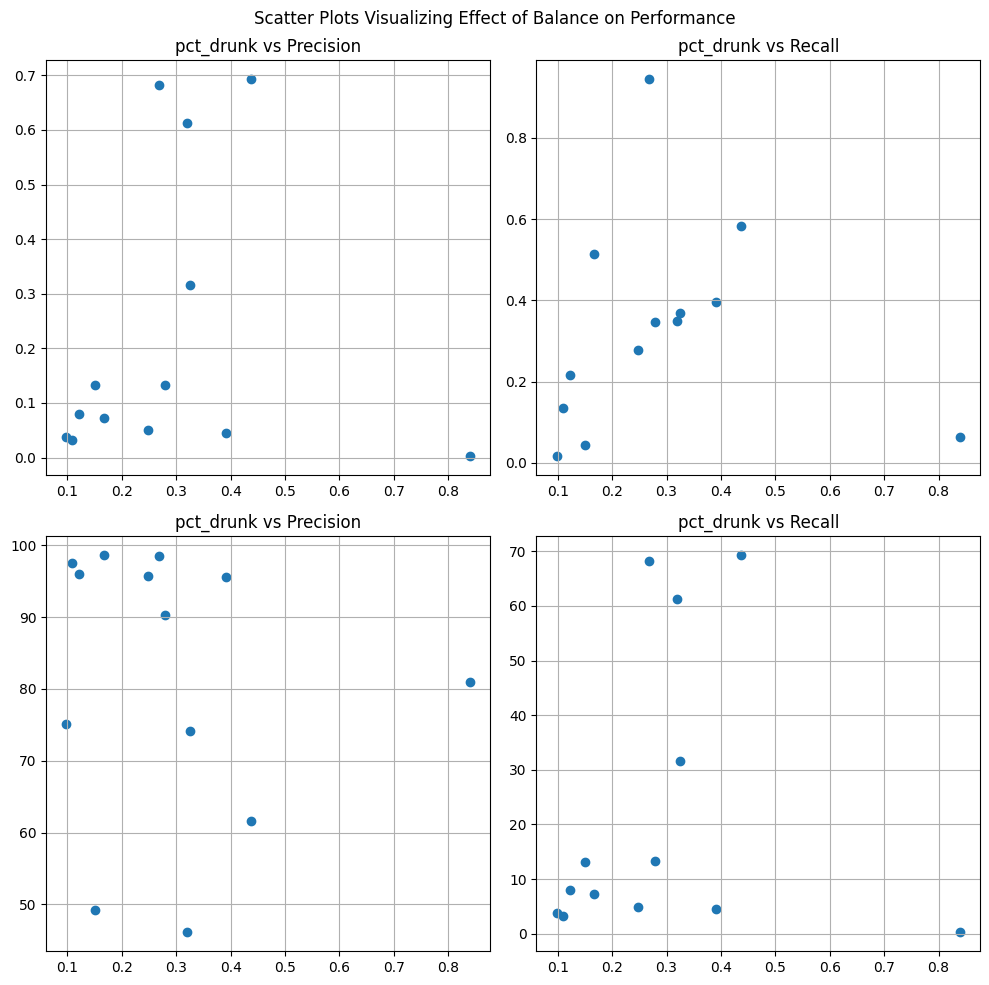

In [201]:
metrics_scatter(baseline_trends)

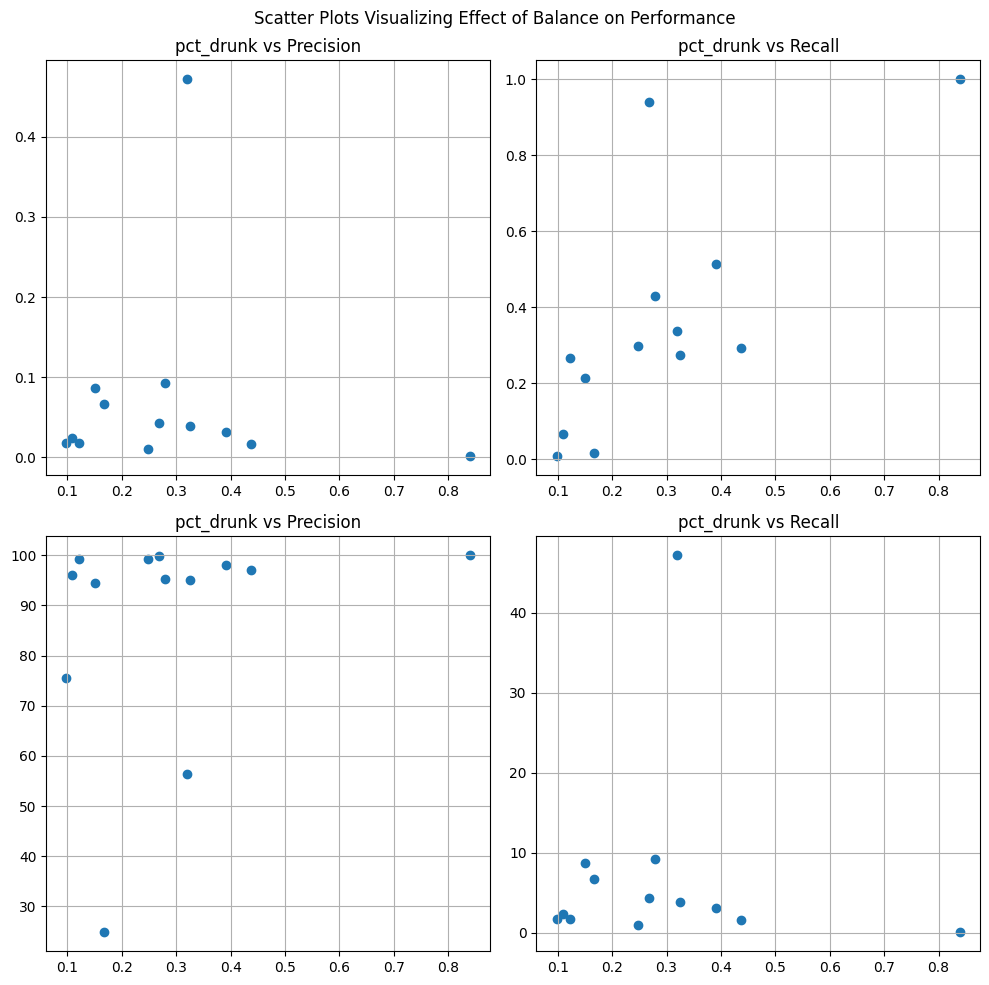

In [241]:
metrics_scatter(gb_trends)

In [272]:
def comparison_scatter(df1, df2):
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))
 
    axes[0, 0].scatter(df1['pct_drunk'], df1['precision'])
    axes[0, 0].set_title('% Drunk Labels vs Baseline Precision')
    axes[0, 0].grid(True)

    axes[0, 1].scatter(df2['pct_drunk'], df2['precision'])
    axes[0, 1].set_title('% Drunk Labels vs Gradient Boosted Precision')
    axes[0, 1].grid(True)

    axes[1, 0].scatter(df1['pct_drunk'], df1['recall'])
    axes[1, 0].set_title('% Drunk Labels vs Baseline Recall')
    axes[1, 0].grid(True)

    axes[1, 1].scatter(df2['pct_drunk'], df2['recall'])
    axes[1, 1].set_title('% Drunk Labels vs Gradient Boosted Recall')
    axes[1, 1].grid(True)

    # Adjust layout
    fig.suptitle('Scatter Plots Visualizing Effect of Balance on Performance')
    plt.tight_layout()

    plt.show()

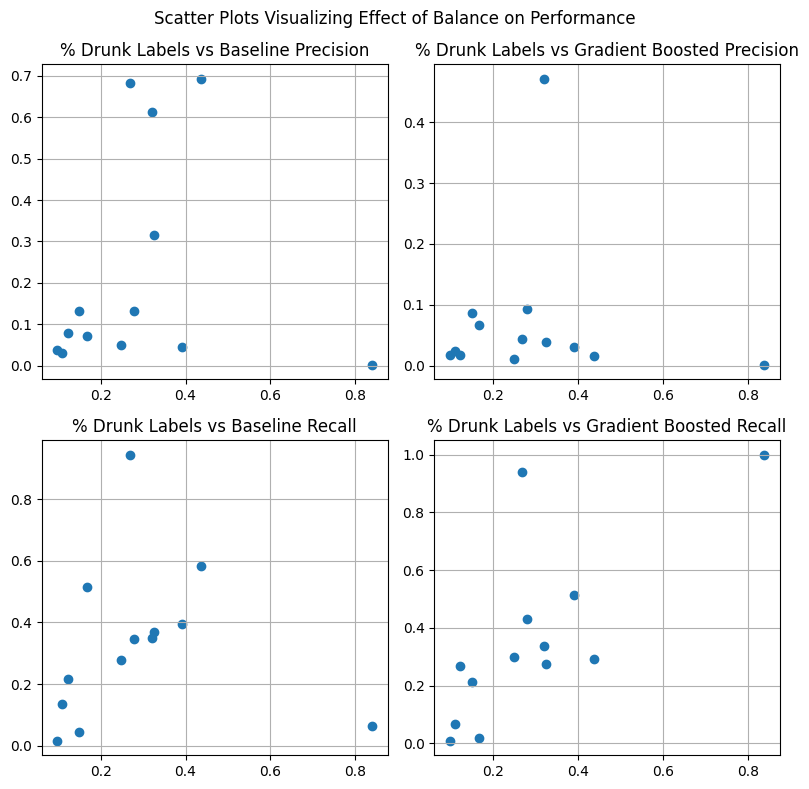

In [273]:
comparison_scatter(baseline_trends, gb_trends)